# 載入所需套件

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas_datareader as pdr
from datetime import datetime
from tqdm import tqdm

style.use('seaborn')
%matplotlib inline

# 從Yahoo Finance抓取美股清單股價資料

In [2]:
#挑選美股清單
tickers=['AMZN','AAPL','NFLX','XOM','T']
start=datetime(2018,1,1)
adjclose_dict={}

for ticker in tqdm(tickers):
    adjclose=pdr.DataReader(ticker,'yahoo',start=start)['Adj Close']
    adjclose_dict[ticker]=adjclose

adjclose_df=pd.DataFrame(adjclose_dict)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]


In [3]:
adjclose_df.head()

,AMZN,AAPL,NFLX,XOM,T
Date,,,,,
2018-01-02,1189.010010,166.353714,201.070007,75.350937,33.197472
2018-01-03,1204.199951,166.324722,205.050003,76.830833,32.430851
2018-01-04,1209.589966,167.097290,205.630005,76.937187,32.732330
2018-01-05,1229.140015,168.999741,209.990005,76.875137,32.852921
2018-01-08,1246.869995,168.372040,212.050003,77.220741,32.947678


# 計算個股每日對數報酬率

In [4]:
log_return=np.log(adjclose_df/adjclose_df.shift(1))

# 計算個股間報酬率共變異數矩陣並做年化處理

In [5]:
cov_matrix=log_return.cov()*252
cov_matrix

,AMZN,AAPL,NFLX,XOM,T
AMZN,0.105735,0.071616,0.095365,0.040666,0.029563
AAPL,0.071616,0.116595,0.075901,0.063966,0.049525
NFLX,0.095365,0.075901,0.181081,0.042049,0.030027
XOM,0.040666,0.063966,0.042049,0.111773,0.054856
T,0.029563,0.049525,0.030027,0.054856,0.079714


# 模擬5000組可能的投資組合

In [6]:
num_port=10000

#建立空向量
all_wts=np.zeros((num_port,len(adjclose_df.columns)))
port_returns=np.zeros((num_port))
port_risk=np.zeros((num_port))
sharpe_ratio=np.zeros((num_port))

In [7]:
for i in tqdm(range(num_port)):
    wts=np.random.uniform(size=len(adjclose_df.columns))
    #使每次模擬投組權重和為1
    wts=wts/np.sum(wts)
    #儲存模擬投組權重結果
    all_wts[i,:]=wts
    
    #計算投組每日報酬率
    port_return=np.sum(log_return.mean()*wts)
    #將投組每日報酬率調整成年化報酬率
    port_return=(port_return+1)**252-1
    #儲存模擬投組年化報酬率結果
    port_returns[i]=port_return
    
    #計算投組年化報酬率波動度
    port_sd=np.sqrt(np.dot(wts.T,np.dot(cov_matrix,wts)))
    #儲存模擬投組年化報酬率波動度結果
    port_risk[i]=port_sd
    
    #計算投組夏普比率,假設無風險利率=0%
    sr=port_return/port_sd
    #儲存模擬投組夏普比率
    sharpe_ratio[i]=sr

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 845.64it/s]


# 最小變異數投資組合(Minimum Variance Portfolio)

In [8]:
min_var_wts=all_wts[port_risk.argmin()]
min_var=port_risk.min()

print('最小變異數投資組合權重 : {}'.format(min_var_wts))
print('最小變異數 : {}'.format(min_var))

最小變異數投資組合權重 : [0.24799931 0.02618205 0.08920282 0.14634672 0.4902691 ]
最小變異數 : 0.24203410268830447


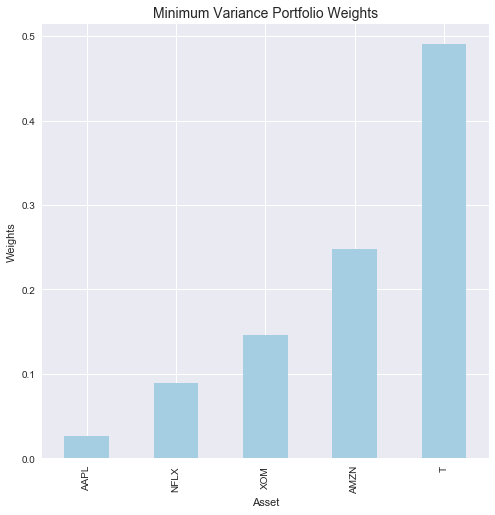

In [9]:
min_var_wts=pd.Series(min_var_wts,index=adjclose_df.columns)
min_var_wts.sort_values(inplace=True)

fig,ax=plt.subplots(1,figsize=(8,8))
ax.set_xlabel('Asset')
ax.set_ylabel('Weights')
ax.set_title('Minimum Variance Portfolio Weights',fontsize=14)
min_var_wts.plot(kind='bar',colormap='Paired',ax=ax)

# 最大夏普比率投資組合(Tangency Portfolio)

In [10]:
max_sr_wts=all_wts[sharpe_ratio.argmax()]
max_sr=sharpe_ratio.max()

print('最大夏普比率投資組合權重 : {}'.format(max_sr_wts))
print('最大夏普比率 : {}'.format(max_sr))

最大夏普比率投資組合權重 : [0.62773264 0.28040907 0.06113768 0.01154401 0.01917659]
最大夏普比率 : 1.3056215878845203


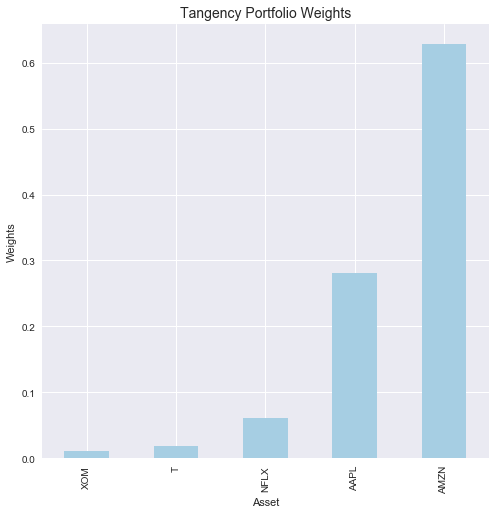

In [11]:
max_sr_wts=pd.Series(max_sr_wts,index=adjclose_df.columns)
max_sr_wts.sort_values(inplace=True)


fig,ax=plt.subplots(1,figsize=(8,8))
ax.set_xlabel('Asset')
ax.set_ylabel('Weights')
ax.set_title('Tangency Portfolio Weights',fontsize=14)
max_sr_wts.plot(kind='bar',colormap='Paired',ax=ax)

# 最適投資組合和效率前緣(Portfolio Optimization and Efficient Frontier)

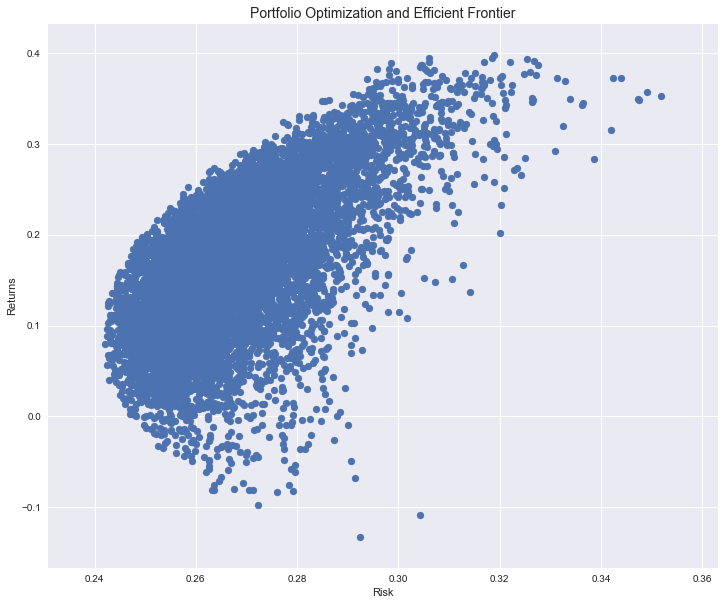

In [12]:
fig,ax=plt.subplots(1,figsize=(12,10))
ax.set_xlabel('Risk')
ax.set_ylabel('Returns')
ax.set_title('Portfolio Optimization and Efficient Frontier',fontsize=14)
ax.scatter(port_risk, port_returns)